# ********
В названии файла я бы поставил сначала имя фамилию)

# ********

In [8]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import numpy as np
import matplotlib.pyplot as plt
import warnings
import scipy.stats as ss
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

# Exercise  1
7Y Bond, annual coupon of 2.5%, currently trading at 102.4.
<br>
7Y Fixed-float Swap is quated at 1.78% par rate. 

a) Calculate Bond $Yield$ and $DV01$ 
<br>
b) Calculate Swap $DV01$ and $hedge$ $ratio$
<br>
<br>
Discount curve given bellow

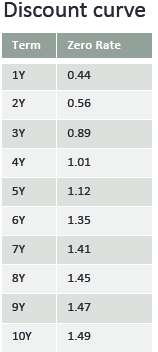

## Solution
a) Discrete case Bond Yield and DV01

<h5>Using following formulas we'll derive Bond's YTM and DV01 in disrete and continious case</h5>

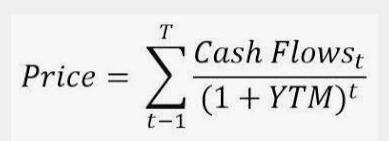
Where Cash Flowes are coupons during all the years, but the last year, where it is coupon + bond's face

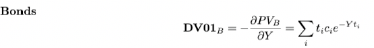
This is a formula for continious case

In [9]:
class Coupon_Bond:
    def get_price(self, coupon, face_value,int_rate,years,freq=1):
        total_coupons_pv=self.get_coupons_pv(coupon,int_rate,years,freq)
        face_value_pv=self.get_face_value_pv(face_value,int_rate,years)
        result = total_coupons_pv + face_value_pv
        return result
    @staticmethod
    def get_face_value_pv(face_value,int_rate, years):
        fvpv=face_value/(1+int_rate)**years
        return fvpv
    def get_coupons_pv(self, coupon, int_rate, years,freq=1):
        pv = 0
        Time=int(years*freq)
        for period in range (Time):
            pv += self.get_coupon_pv(coupon,int_rate,period+1,freq)
        return pv 
    @staticmethod
    def get_coupon_pv(coupon, int_rate,period,freq):
        pv = coupon / (1+int_rate/freq)**period
        return pv
    def get_ytm (self, bond_price, face_value, coupon, years, freq=1,estimate = 0.01):
        get_yield = lambda int_rate: self.get_price(coupon,face_value,int_rate,years,freq)-bond_price
        return optimize.newton(get_yield,estimate)
    def get_DVO1 (self,bond_price, face_value, coupon, years, freq=1,estimate = 0.01):
        DV=(face_value* years) / (1+self.get_ytm (bond_price, face_value, coupon, years))**(years+1)
        Time=int(years*freq)
        for period in range (Time):
            DV += self.get_coupon_pv((period+1)*coupon,self.get_ytm (bond_price, face_value, coupon, years),period+2,freq)
        return DV * 0.01

In [10]:
coupon_bond_calc= Coupon_Bond()
YTM_discr = coupon_bond_calc.get_ytm(bond_price=102.4,face_value=100.0,coupon=2.5,years=7.0,freq=1.0)
DV01_b_discr =  coupon_bond_calc.get_DVO1(bond_price=102.4,face_value=100.0,coupon=2.5,years=7.0)
print('Bond yield = {:.2f}%'.format(YTM_discr*100),
     ', DV01 = {:.2f}'.format(DV01_b_discr))

Bond yield = 2.13% , DV01 = 6.53


In [11]:
# using numpy_financial
import numpy_financial as npf
YTM=npf.rate(pv=-102.4,nper=7,pmt=2.5,fv=100)
price=102.4
price_up=-npf.pv(rate=YTM+0.01,nper=7,pmt=2.5,fv=100)
price_down=-npf.pv(rate=YTM-0.01,nper=7,pmt=2.5,fv=100)
duration=(price_down-price_up)/(price*2*0.01)
DV01=duration*price*0.01
print('Bond yield = {:.2f}%'.format(YTM*100),', DV01 = {:.2f}'.format(DV01))

Bond yield = 2.13% , DV01 = 6.54


a) Continious case Bond Yield and DV01

In [12]:
class Coupon_Bond_cont:
    def get_price(self, coupon, face_value,int_rate,years,freq=1):
        total_coupons_pv=self.get_coupons_pv(coupon,int_rate,years,freq)
        face_value_pv=self.get_face_value_pv(face_value,int_rate,years)
        result = total_coupons_pv + face_value_pv
        return result
    @staticmethod
    def get_face_value_pv(face_value,int_rate, years):
        fvpv = face_value *np.exp(-(int_rate*years))
        return fvpv
    def get_coupons_pv(self, coupon, int_rate, years,freq=1):
        pv = 0
        Time=int(years*freq)
        for period in range (Time):
            pv += self.get_coupon_pv(coupon,int_rate,period+1,freq)
        return pv 
    @staticmethod
    def get_coupon_pv(coupon, int_rate,period,freq):
        pv = coupon * np.exp(-(int_rate*period)/freq)
        return pv
    def get_ytm (self, bond_price, face_value, coupon, years, freq=1,estimate = 0.01):
        get_yield = lambda int_rate: self.get_price(coupon,face_value,int_rate,years,freq)-bond_price
        return optimize.newton(get_yield,estimate)
    #@staticmethod
    def get_DVO1 (self,bond_price, face_value, coupon, years, freq=1,estimate = 0.01):
        DV=years*face_value*np.exp(-self.get_ytm (bond_price, face_value, coupon, years)* (years))
        #DV=0
        Time=int(years*freq)
        for period in range (Time):
            DV += (period+1) * coupon * np.exp(-self.get_ytm (bond_price, face_value, coupon, years)* (period+1) )
        return DV * 0.01

In [13]:
coupon_bond_calc= Coupon_Bond_cont()
YTM_cont = coupon_bond_calc.get_ytm(bond_price=102.4,face_value=100.0,coupon=2.5,years=7.0,freq=1.0)
DV01_b =  coupon_bond_calc.get_DVO1(bond_price=102.4,face_value=100.0,coupon=2.5,years=7.0)
print('Bond yield = {:.2f}%'.format(YTM_cont*100),
     ', DV01 = {:.2f}'.format(DV01_b))

Bond yield = 2.11% , DV01 = 6.67


b) Swap DV01 and hedge ratio

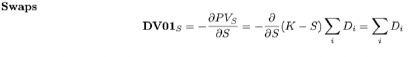
Simillar formula to Bond DV01

In [14]:
Spot_rates=[0.44,0.56,0.89,1.01,1.12,1.35,1.41,1.45,1.47,1.49]
Spot_rates=[x/100 for x in Spot_rates]

class Swap:
    @staticmethod
    def get_DV01 (int_rate,years, freq=1):
        DV=0
        Time=int(years*freq)
        for period in range (Time):
            DV += np.exp(int_rate[period]*(period+1))
        return DV
Swap_calc= Swap()
DV01_S=Swap_calc.get_DV01(Spot_rates,7.0)
print('Swap DV01: {:.2f}'.format (DV01_S))

Swap DV01: 7.33


## Hedge Ratio comes from equality: 
<br>
<em> Bonds * DV01 (Bond) = Swaps * DV01 (Swap) </em>
<br>
    From where we get our hedge ratio:
<br>
    <em> Hedge Ratio =  DV01 (Swap) / DV01 (Bond) </em>
<br> In our case we will use continious DV01 for bonds       
   

In [15]:
Hedge_ratio = DV01_S / DV01_b_discr
print('Swap DV01: {:.2f}'.format (Hedge_ratio))

Swap DV01: 1.12


# Exercise  2.1
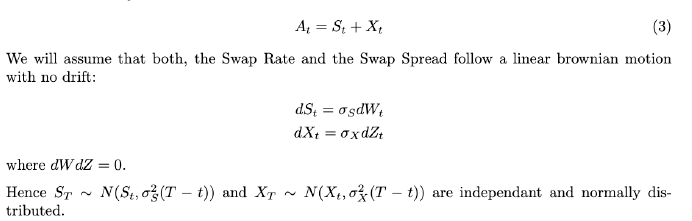
a) Compute volatiliy $\sigma_A$ of a process $A_t$
<br> b) Compute correlation between $A_t$ and $S_t$

# Solution

a)
Volatility $ \sigma = \sqrt {Dispersion} $
<br> As we know that $S_t$ and $X_t$ are independant, covariation between  $S_t$ and $X_t$ equals to zero.

<br> Thus $D_A$ = $D_S$ +$D_X$
<br> By using Îto lemma we calculate $S_t =\sigma_S W_t $ and $ X_t =\sigma_X Z_t $ and each $W_t$  and $Z_t$  follows normal disribution with zero mean and variance = t ( $S_t$ follows $N(0,\sigma_S^2t)$
<br>
<br> Thus $D_A$ = $\sigma_S^2 t$ +$\sigma_X^2 t = t(\sigma_S^2+\sigma_X^2)$
<br> And volatility $\sigma_A$ = $\sqrt D_A$ = $\sqrt {t(\sigma_S^2+\sigma_X^2)}$

# ********

В а) были зависимости $\sigma_*(T-t)$, где для поиска просто $\sigma_*$ искали d*. Тут для поиска тоже надо было искать dA.

# ********

b) Correlation between $A_t$ and $S_t$ is determined by formula
<br>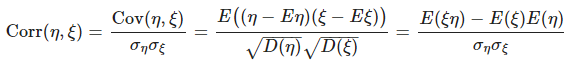

Thus in our case $Corr(A_t,S_t) = \frac{E(A_tS_t) - E(A_t)E(S_t)}{\sigma_{A_t} \sigma_{S_t}} = \frac{E((S_t)^2+S_tX_t) - E(S_t+X_t)E(S_t)}{\sigma_{A_t} \sigma_{S_t}} =$
<br>
$=\frac{E((S_t^2)+E(S_tX_t) - (E(S_t)+E(X_t))E(S_t)}{\sqrt{ t(\sigma_S^2+\sigma_X^2)\sigma_S^2t}}$ = || as $dWdZ = 0$ we have $E(SX) = 0 $ || $=\frac{E(S_t^2)-(E(S_t)+E(X_t))E(S_t)}{\sqrt{ t(\sigma_S^2+\sigma_X^2)\sigma_S^2t}}= $
<br>$ =\frac{E(S_t^2)-(E(S_t)+E(X_t))E(S_t)}{\sigma_S t\sqrt{ \sigma_S^2+\sigma_X^2}} = $ || X and S follows Normal distribution with zero mean || = $ \frac{\sigma_S^2 t}{\sigma_S t\sqrt{ \sigma_S^2+\sigma_X^2}} = \frac{\sigma_S}{\sqrt{ \sigma_S^2+\sigma_X^2}}$
<br>
So $$ Corr(A_t,S_t) = \frac{\sigma_S}{\sqrt{ \sigma_S^2+\sigma_X^2}} $$

# Exercise 2.2
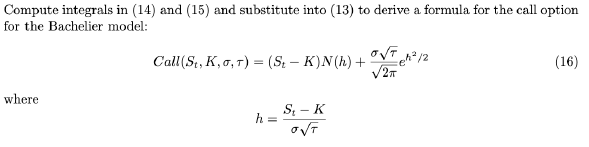

## Solution
We have 
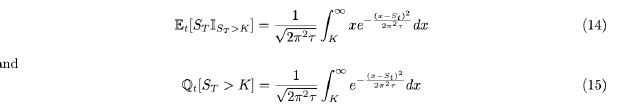

(14): $$ \frac{1}{\sqrt{2 \pi \sigma^2\tau}} \int_{K}^{\infty} x e^{-(x-S_t)^2/2\sigma^2\tau} \,dx $$ = $|change \frac{X-S_t}{\sigma \sqrt \tau} = b |$
$$=\frac{\sigma\sqrt\tau}{\sqrt{2 \pi \sigma^2\tau}} \int_{-h}^{\infty} (b\sigma \sqrt \tau + S_t) e^{-b^2/2} \,db $$,
<br>  where $ h = \frac{S_t-K}{\sigma\sqrt\tau}$
$$=\frac{\sigma\sqrt\tau}{\sqrt{2 \pi \sigma^2\tau}} \int_{-h}^{\infty} (b\sigma \sqrt \tau + S_t) e^{-b^2/2} \,db $$,

$$=\frac{\sigma\sqrt\tau}{\sqrt{2 \pi}} \int_{-h}^{\infty} b e^{-b^2/2} \,db + \frac{S_t\sigma\sqrt\tau}{\sqrt{2 \pi \sigma^2\tau}} \int_{-h}^{\infty} e^{-b^2/2} \,db $$,
$$ =\frac{\sigma\sqrt\tau}{2\sqrt{2 \pi}} \int_{-h}^{\infty}e^{-b^2/2} \,db^2 + S_tN(h)$$,

$$=\frac{\sigma\sqrt\tau}{\sqrt{2 \pi}}e^{-h^2/2} + S_tN(h) = (14)$$,

And (15):
$$\frac{1}{\sqrt{2 \pi \sigma^2\tau}} \int_{K}^{\infty}e^{-(x-S_t)^2/2\sigma^2\tau} \,dx  $$   | we use the same tactics of change change $\frac{X-S_t}{\sigma \sqrt \tau} = b$  and we obtain
$$ N(h) = (13)$$

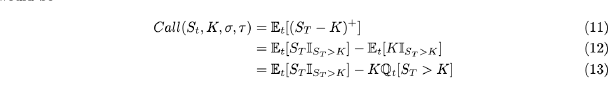

Putting results into (13) we obtain  $\frac{\sigma\sqrt\tau}{\sqrt{2 \pi}}e^{-h^2/2} + S_tN(h) - KN(h) = Call(S_t, K, \sigma,\tau) $


As we can see, the Call price is a bit different than it was given in the exercise. Here is another interpretation of Bachelier formula, it's written a bit different way. For example, here is a Call price, given from https://arxiv.org/pdf/2104.08686.pdf
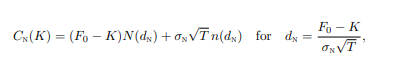

# Exercise 2.3
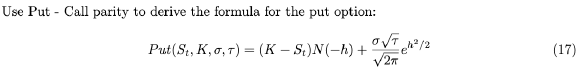

Put-Call parity is $$ Call + Ke^{-rt} = S_t + Put $$

in our case r = 0, $ Call = (S_t-K)N(h)+\frac{\sigma \sqrt\tau}{\sqrt{2\pi}}e^{-h^2/2}$
<br>So Put: $$ Put = (S_t-K)(1-N(-h))+\frac{\sigma \sqrt\tau}{\sqrt{2\pi}}e^{-h^2/2} + K - S_t $$ or 
$$ Put = (K-S_t)N(-h)+\frac{\sigma \sqrt\tau}{\sqrt{2\pi}}e^{-h^2/2} $$

# Exercise 2.4
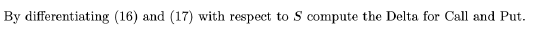

Delta for Call:
$$Call'_S =(\frac{\sigma\sqrt\tau}{\sqrt{2 \pi}}e^{-h^2/2} + (S_t- K)N(h))'_S = $$
$h = \frac{S_t-K}{\sigma\sqrt\tau}$

$$\frac{\sigma\sqrt\tau}{\sqrt{2 \pi}}(-h)e^{-h^2/2} \frac{1}{\sigma\sqrt\tau} + N(h)+(S_t-K)\frac{1}{\sqrt{2\pi}}e^{-h^2/2}\frac{1}{\sigma\sqrt\tau} =$$
$$=(\frac{-h\sigma\sqrt\tau+ S_t - K}{\sigma\sqrt{2 \pi\tau}})e^{-h^2/2} + N(h) $$ 
| substitude h and we obtain | $ N(h) $
So $$Delta (Call) = Call'_S = N(h)$$

For Put option we have the same calculation and we obtain: $$ Delta(Put) = Put'_S = -N(-h) $$

# Exercise 2.5

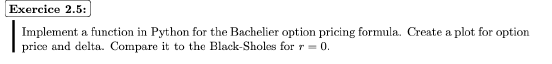

In [158]:
class Bachelier:
    @staticmethod
    def Call (K, S,sigma,tau):
        h= (S-K)/(sigma*np.sqrt(tau))
        N_h=ss.norm.cdf(h,loc = 0, scale = 1)
        return (S-K)*N_h+(sigma*np.sqrt(tau)*np.exp((-0.5*h**2)))/np.sqrt(2*np.pi)
    @staticmethod
    def Put (K, S,sigma,tau):
        h= (S-K)/(sigma*np.sqrt(tau))
        N_h=ss.norm.cdf(-h,loc = 0, scale = 1)
        return (K-S)*N_h+(sigma*np.sqrt(tau)*np.exp((-0.5*h**2)))/np.sqrt(2*np.pi)
    @staticmethod
    def Delta_Call (K, S, sigma,tau):
        h= (S-K)/(sigma*np.sqrt(tau))
        N_h=ss.norm.cdf(h)
        return N_h
    @staticmethod
    def Delta_Put (K, S, sigma,tau):
        h= (S-K)/(sigma*np.sqrt(tau))
        N_h=ss.norm.cdf(-h)
        return N_h
St = 50
Volatility = 0.3
K = 50
Time_to_maturity = 180 / 365
#ts=(St-K)/(Volatility*np.sqrt(Time_to_maturity))
#print(ts,ss.norm.pdf(ts))
Option= Bachelier()
print ('Option price inputs: Strike = ', K,', Stock Price = ',St,', Volatility = ',Volatility,'tau = ', Time_to_maturity*365)
print('Call Price: {:.2f}'.format (Option.Call(K,St,Volatility,Time_to_maturity)),'Call Delta: {:.2f}'.format (Option.Delta_Call(K,St,Volatility,Time_to_maturity)))

Option price inputs: Strike =  50 , Stock Price =  50 , Volatility =  0.3 tau =  180.0
Call Price: 0.08 Call Delta: 0.50


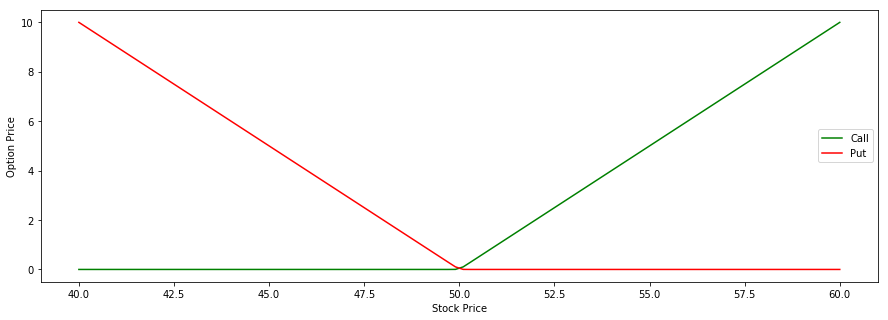

In [276]:
St = np.linspace (40,60,100)
Volatility = 0.1
K = 50
Time_to_maturity = 0.5

Call_pricing = lambda x: Option.Call(K,x,Volatility,Time_to_maturity)
Call= Call_pricing(St)

Put_pricing = lambda x: Option.Put(K,x,Volatility,Time_to_maturity )
Put= Put_pricing(St)

plt.figure(figsize=(15,5))
plt.plot(St,Call,'g',label = 'Call')
plt.plot(St,Put, 'r',label = 'Put')
plt.legend()
plt.ylabel('Option Price')
plt.xlabel('Stock Price')
plt.show()

# ********
Предлагаю тут еще сравнить результаты, которые при одних и тех же параметрах дадут модели и объяснить результат.

# ********

# Exercise 3.

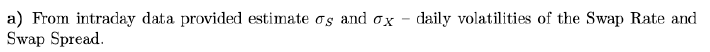

We have 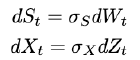
where $S_t$ - Swap Rate, $X_t$ - Swap Spread.

In [308]:
Data = pd.read_csv('SwapRates.csv', index_col=0)
St = Data['USSWAP2Y']
Xt =St - Data['USGOVT2Y']

# considering Xt and St as % change in rate
Xt = Xt.pct_change()
St = St.pct_change()
sigma_x = Xt.std() 
sigma_s = St.std()
Xt.dropna(inplace = True)
St.dropna(inplace = True)
# considering Xt and St as real rate
#Xt = Xt
#St = St
#sigma_x = Xt.std() 
#sigma_s = St.std() 

In [309]:
print ('Sigma St = ', np.round(sigma_s,2),', Sigma Xt = ', np.round(sigma_x,2),)

Sigma St =  0.03 , Sigma Xt =  1.01


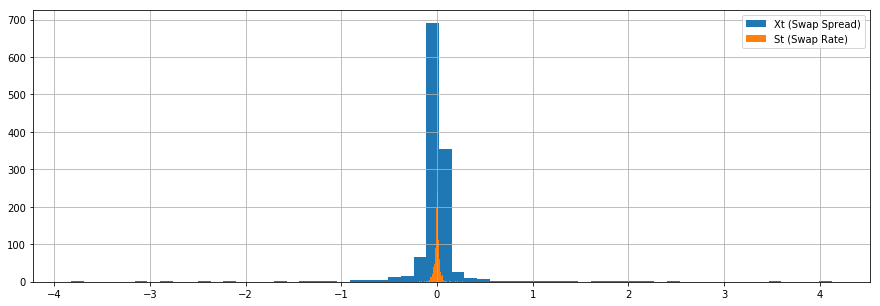

In [310]:
# if we consider % change in rate filtered with values less than 50% change
plt.figure(figsize=(15,5))
Xt_ch = Xt[Xt>-5]
Xt_ch[Xt_ch<5].hist(bins = 60)
St.hist(bins = 60)
plt.legend(['Xt (Swap Spread)','St (Swap Rate)'])
plt.show()

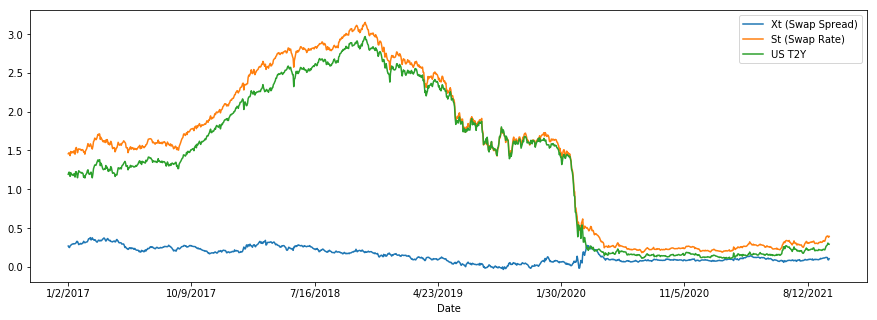

In [250]:
# considering Xt and St as real rate
plt.figure(figsize=(15,5))
Xt.plot()
St.plot()
Data['USGOVT2Y'].plot()
plt.legend(['Xt (Swap Spread)','St (Swap Rate)','US T2Y'])
plt.show()

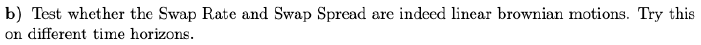

In order to check if it's a linear brownian motion we will focus on checking last condition:
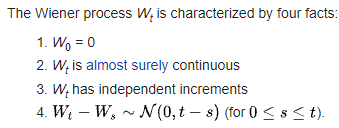

So we need to check 1) normality of variation, 2) mean zero of variation, 3) dispersion of process = t-s
<br>
1) Shapiro test won't work as we have relatively low ammount of data ( ~ 1k), so we try Anderson test
<br>
2) we use T-test for mean
<br>
3) we can test same lag difference, to check that they have same dispersion( 900 - 200 = 1100 - 400 ) - We use Levene test for that


### testing hypothesis for Xt

In [311]:
import scipy.stats as ss
Attempt = 0
Good_norm = 0
Good_mean = 0
for t in range (100,1100,10):
    for j in range (t+500,1200,10):
        Bs = Xt[t:j]
        Bs.dropna(inplace = True)
        Attempt+=1
        
        #if (ss.normaltest(Bs)[1]> 0.1): # 10 % threshold
        #    Good_norm +=1   
        
        #Anderson test - if the returned statistic is larger than these critical values then for the corresponding significance level,
        #the null hypothesis that the data come from the chosen distribution can be rejected.
        if (ss.anderson(Bs, dist='norm')[0] < ss.anderson(Bs, dist='norm')[1][2]): # 5 % threshol
            Good_norm +=1
        # T-test
        if (ss.ttest_1samp(Bs,0)[1]> 0.05): # 5 % threshold
            Good_mean +=1
    #The Levene test tests the null hypothesis that all input samples are from populations with equal variances.
temp = 0
temp1 = 0
for j in range (100,650,50):    
    if (ss.levene(Xt[j:j+500],Xt[j+150:j+650])[1]>0.05): # 5 % threshold
        temp1+=1
    temp +=1

        #print('Student test for zero mean',ss.ttest_1samp(Bs,0))
        #print('Xj - Xt mean =',np.round(Bs.mean(),3),'\n')
print('Ratio of normal samples: ',Good_norm / Attempt, ', Ratio of zero-mean samples: ',Good_mean / Attempt )

if (Good_norm / Attempt > 0.5):
    print ('It is probably normal distribution')
else:
    print ('It is probably not normal distribution') 

if (Good_mean / Attempt > 0.5):
    print ('It has probably zero mean')
else:
    print ('It has not probably zero mean') 
    
if (temp1 / temp > 0.5):
    print ('It is probably simillar variance')
else:
    print ('It is probably not simillar variance') 

Ratio of normal samples:  0.0 , Ratio of zero-mean samples:  1.0
It is probably not normal distribution
It has probably zero mean
It is probably simillar variance


### testing hypothesis for St

In [320]:
Attempt = 0
Good_norm = 0
Good_mean = 0
for t in range (100,1100,10):
    for j in range (t+500,1200,10):
        Bs = St[t:j]
        Bs.dropna(inplace = True)
        Attempt+=1
        #Anderson test - if the returned statistic is larger than these critical values then for the corresponding significance level,
        #the null hypothesis that the data come from the chosen distribution can be rejected.
        if (ss.anderson(Bs, dist='norm')[0] < ss.anderson(Bs, dist='norm')[1][2]): # 5 % threshol
            Good_norm +=1
        # T-test
        if (ss.ttest_1samp(Bs,0)[1]> 0.05): # 5 % threshold
            Good_mean +=1
    #The Levene test tests the null hypothesis that all input samples are from populations with equal variances.
temp = 0
temp1 = 0
for j in range (100,650,50):    
    if (ss.levene(Xt[j:j+500],Xt[j+150:j+650])[1]>0.05): # 5 % threshold
        temp1+=1
    temp +=1

if (Good_norm / Attempt > 0.5):
    print ('It is probably normal distribution')
else:
    print ('It is probably not normal distribution') 

if (Good_mean / Attempt > 0.5):
    print ('It has probably zero mean')
else:
    print ('It has not probably zero mean') 
    
if (temp1 / temp > 0.5):
    print ('It is probably simillar variance')
else:
    print ('It is probably not simillar variance') 

It is probably not normal distribution
It has probably zero mean
It is probably simillar variance


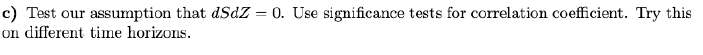

We use Pearson correlation and its test with null hypothesis of correlation equals to zero

In [319]:
from scipy.stats.stats import pearsonr
temp = 0
temp1 = 0
for t in range (10,1200):
    #print(t)
    #print ('Pearson correlation is equal to {:.2f}'.format(pearsonr(Xt[:t],St[:t])[0]),'with p-value of {:.1e}'.format(pearsonr(Xt[:t],St[:t])[1]))
    
    #The P-value is the probability that you would have found the current result if the correlation coefficient were in fact zero (null hypothesis).
    #If this probability is lower than the conventional 5% (P<0.05) the correlation coefficient is called statistically significant.
    if (abs(pearsonr(Xt[:t],St[:t])[0])>0.01) and (pearsonr(Xt[:t],St[:t])[1] < 0.05):
        temp1+=1
    temp +=1
    #print (pearsonr(Xt[:t],St[:t])[1])
if (temp1/temp > 0.5):
    print ('Correlation exists!')
else:
    print('Correlation probably not exists')    

Correlation probably not exists
